In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Portfolio

I am using a top down methods to construct a portfolio.

* First division: Equity, and Bond

________

* Second division:

1. Equity: (Regions)
* NA: IVV
* EU: UK(EWU), Others(FEZ)
* ASIA: VPL

* Emerging: VWO

2. Bond: 
* Government Bond: GOVT
* Corporate Bond: VCIT
* High Yield Bond: USHY

* Emerging: VWOB







In [531]:
tickers = ['IVV', 'EWU', 'FEZ', 'VPL', 'VWO', 'GOVT', 'VCIT', 'USHY', 'VWOB']

In [532]:
df = yf.download(tickers)
df = df['Adj Close'].dropna()
df = df[tickers]

[*********************100%%**********************]  9 of 9 completed


<Axes: xlabel='Date'>

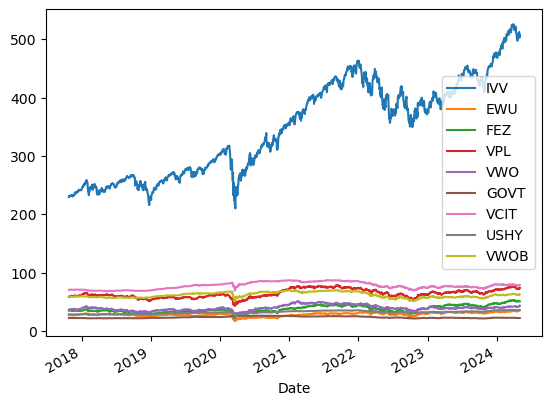

In [533]:
df.plot()

# First: Optimal portfolio (Efficient Frontier)

## Minimum Variance Portfolio

In [534]:
log_ret = np.log(df / df.shift()).dropna()
cov_matrix = log_ret.cov() * 252
cov_matrix

,IVV,EWU,FEZ,VPL,VWO,GOVT,VCIT,USHY,VWOB
IVV,0.040496,0.032756,0.037863,0.030413,0.031906,-0.001969,0.004072,0.013995,0.012858
EWU,0.032756,0.041723,0.041393,0.030708,0.032345,-0.001958,0.003794,0.012630,0.013113
FEZ,0.037863,0.041393,0.050734,0.034568,0.036767,-0.001645,0.004899,0.014389,0.015624
VPL,0.030413,0.030708,0.034568,0.031895,0.031190,-0.001063,0.003640,0.011230,0.011663
VWO,0.031906,0.032345,0.036767,0.031190,0.042859,-0.001385,0.003711,0.011547,0.013020
GOVT,-0.001969,-0.001958,-0.001645,-0.001063,-0.001385,0.003158,0.002695,0.000478,0.002197
VCIT,0.004072,0.003794,0.004899,0.003640,0.003711,0.002695,0.004983,0.003637,0.005195
USHY,0.013995,0.012630,0.014389,0.011230,0.011547,0.000478,0.003637,0.008284,0.007109
VWOB,0.012858,0.013113,0.015624,0.011663,0.013020,0.002197,0.005195,0.007109,0.011656


In [535]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

correlation_from_covariance(cov_matrix)

,IVV,EWU,FEZ,VPL,VWO,GOVT,VCIT,USHY,VWOB
IVV,1.000000,0.796890,0.835348,0.846232,0.765859,-0.174101,0.286618,0.764080,0.591801
EWU,0.796890,1.000000,0.899687,0.841778,0.764889,-0.170555,0.263130,0.679336,0.594637
FEZ,0.835348,0.899687,1.000000,0.859335,0.788479,-0.129968,0.308120,0.701846,0.642473
VPL,0.846232,0.841778,0.859335,1.000000,0.843587,-0.105970,0.288694,0.690856,0.604874
VWO,0.765859,0.764889,0.788479,0.843587,1.000000,-0.119056,0.253958,0.612787,0.582513
GOVT,-0.174101,-0.170555,-0.129968,-0.105970,-0.119056,1.000000,0.679462,0.093402,0.362195
VCIT,0.286618,0.263130,0.308120,0.288694,0.253958,0.679462,1.000000,0.566067,0.681585
USHY,0.764080,0.679336,0.701846,0.690856,0.612787,0.093402,0.566067,1.000000,0.723427
VWOB,0.591801,0.594637,0.642473,0.604874,0.582513,0.362195,0.681585,0.723427,1.000000


In [536]:
n_investments = len(df.columns)
weights = np.array([1/n_investments for _ in range(n_investments)])

# Objective function: Portfolio Variance
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights 

# Constraints: Weights sum to 1
cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Bounds for each weight
bounds = ((0.025, 1 - 1e-5) for _ in range(n_investments))

# Minimize the portfolio variance
result = minimize(portfolio_variance, weights, args=(cov_matrix,),
                  method='SLSQP', bounds=bounds, constraints=cons)

print("Optimal weights:", result.x)
print("Minimum variance:", result.fun)

Optimal weights: [0.025 0.025 0.025 0.025 0.025 0.8   0.025 0.025 0.025]
Minimum variance: 0.0026927998003066908


In [537]:
0.225 + 0.075 + 0.15 + 0.225 + 0.225 + 0.075 + 0.025

0.9999999999999999

## Efficient Frontier

In [538]:

# Calculate covariance matrix and expected returns
n_investments = len(df.columns)
mu = np.array(df.pct_change().dropna().mean()) * 252 # Daily returns mean
weights = np.array([1/n_investments] * n_investments)

n_port = 100
port_ret = np.zeros(n_port)
port_var = np.zeros(n_port)
port_weight = np.zeros((n_port, n_investments))

# Objective function: Mean-Variance Portfolio
def mean_variance_portfolio(weights, cov_matrix, mu, lambda_risk_preference):
    # Portfolio variance
    variance = weights.T @ cov_matrix @ weights
    # Expected portfolio return
    expected_return = mu @ weights
    # Objective function: minimize variance and maximize return
    return variance - lambda_risk_preference * expected_return

# Constraint: Weights sum to 1
cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

# Bounds for each weight (no short selling and minimum 2.5% investment)
bounds = [(0.025, 1) for _ in range(n_investments)]

# Minimize the mean-variance objective function

for i in range(n_port):
    lambda_risk_preference = 0.04 * i
    result = minimize(mean_variance_portfolio, weights, args=(cov_matrix, mu, lambda_risk_preference),
                    method='SLSQP', bounds=bounds, constraints=cons)
    port_weight[i, :] = result.x
    port_ret[i] = mu @ result.x
    port_var[i] = result.x.T @ cov_matrix @ result.x

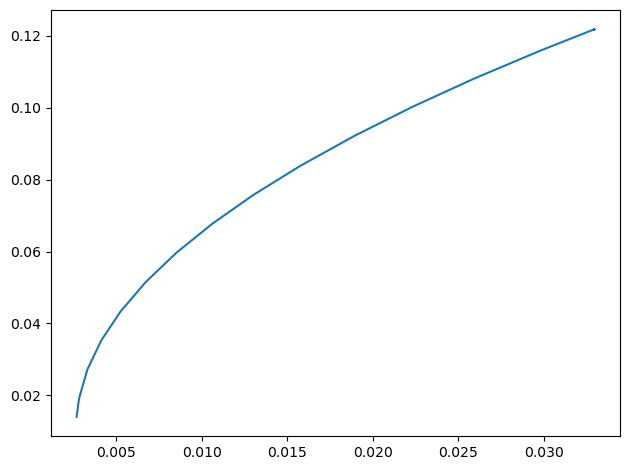

In [539]:
plt.plot(port_var, port_ret)
plt.tight_layout()
plt.show()

In [540]:
max_idx = np.argmax(port_ret)
max_ret = port_ret[max_idx]
max_var = port_var[max_idx]
max_weight = port_weight[max_idx,:]
print("The return of the portfolio is {}".format(max_ret))
print("The variance of the portfolio is {}".format(max_var))
print("Optimal weight is {}".format(max_weight))

The return of the portfolio is 0.12183922471655347
The variance of the portfolio is 0.03294189697188357
Optimal weight is [0.8   0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025]


In [541]:
df_weight_1 = pd.DataFrame(max_weight, index=df.columns, columns=['Weight'])
df_weight_1

,Weight
IVV,0.800
EWU,0.025
FEZ,0.025
VPL,0.025
VWO,0.025
GOVT,0.025
VCIT,0.025
USHY,0.025
VWOB,0.025


The maximum return portfolio yields extreme portfolio, because the mean of US equity has the largest mean.

# Risk weighting

In [551]:
weights = np.array([0.3375, 0.05625, 0.1125, 0.16875, 0.225, 0.025, 0.025, 0.025, 0.025])
#weights = np.array([0.225, 0.075, 0.15, 0.225, 0.225, 0.025, 0.025, 0.025, 0.025])

sum(weights)

1.0

We include trailing sharpe ratio as the momentum indicator where we invest more into assets that increase in value in last 12 months.

In [563]:
df_1y = df[-253:]
ret_1y = df_1y.pct_change().dropna()
mu_1y = ret_1y.mean() * 252
sigma_1y = ret_1y.std() * np.sqrt(252)
sharpe_annual = mu_1y / sigma_1y
factors = 1 + (sharpe_annual - sharpe_annual.mean()) / sharpe_annual.std()
weights_adjusted = weights * factors
weights_adjusted[weights_adjusted < 0] = 0
weight_final = weights_adjusted / sum(weights_adjusted)


# Adjusted risk weighting after considering momentum indicator as our forecast model 

In [564]:
print('final risk weight')
print(weight_final)

final risk weight
IVV     0.566984
EWU     0.029294
FEZ     0.076627
VPL     0.119256
VWO     0.153532
GOVT    0.000000
VCIT    0.003553
USHY    0.034711
VWOB    0.016042
dtype: float64


In [565]:
ret = df.pct_change().dropna()
std = ret.std() * np.sqrt(252)

df_adjusting = pd.DataFrame({'ret': mu, 'std':std})
df_adjusting

,ret,std
IVV,0.142203,0.200462
EWU,0.061204,0.202934
FEZ,0.083913,0.223859
VPL,0.052011,0.177769
VWO,0.047114,0.205814
GOVT,0.003026,0.056205
VCIT,0.019613,0.070642
USHY,0.040582,0.090913
VWOB,0.015621,0.107176


We choose the average volatility as the target volatility.

In [566]:
avg_std = df_adjusting['std'].mean()
df_adjusting['volatility_ratio'] = avg_std / df_adjusting['std']
df_adjusting['risk_weight'] = weight_final
df_adjusting['cash_weight'] = df_adjusting['risk_weight'] * df_adjusting['volatility_ratio']
df_adjusting['final_cash_weight'] = df_adjusting['cash_weight'] / sum(df_adjusting['cash_weight'])
df_adjusting['cash_amount'] = 35000 * df_adjusting['final_cash_weight']
df_adjusting['share'] = df_adjusting['cash_amount'] / df.iloc[-1, :]
df_adjusting['share'] = df_adjusting['share'].astype('int')
df_adjusting

,ret,std,volatility_ratio,risk_weight,cash_weight,final_cash_weight,cash_amount,share
IVV,0.142203,0.200462,0.740385,0.566984,0.419786,0.532286,18630.000149,36
EWU,0.061204,0.202934,0.731368,0.029294,0.021425,0.027167,950.833122,27
FEZ,0.083913,0.223859,0.663003,0.076627,0.050804,0.064419,2254.653719,44
VPL,0.052011,0.177769,0.834900,0.119256,0.099567,0.126250,4418.753298,59
VWO,0.047114,0.205814,0.721135,0.153532,0.110718,0.140389,4913.612656,113
GOVT,0.003026,0.056205,2.640677,0.000000,0.000000,0.000000,0.000000,0
VCIT,0.019613,0.070642,2.100998,0.003553,0.007466,0.009467,331.334118,4
USHY,0.040582,0.090913,1.632540,0.034711,0.056668,0.071854,2514.901862,69
VWOB,0.015621,0.107176,1.384823,0.016042,0.022215,0.028169,985.911077,15


In [567]:
cash_weight = df_adjusting['final_cash_weight']
equity_weight = sum(cash_weight[:6])
bond_weight = sum(cash_weight[6:])
print('Portfolio allocation: ({} Equity {} Bond)'.format(equity_weight, bond_weight))

Portfolio allocation: (0.8905100840763541 Equity 0.10948991592364588 Bond)


In [568]:
mu @ cash_weight

0.09948303548159834

In [569]:
cash_weight.T @ cov_matrix @ cash_weight

0.030897647470250495